In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import shap
import seaborn as sns


RANDOM_STATE = 590

In [2]:
df = pd.read_csv('Data in Table S6 of the Supporting Information')

In [3]:
print(df.shape)
df.head()

(35, 15)


,atom_N,Radii,chemi_pot,out_e,i1,electron affinity (kJ/mol),badar charge (e),binding energy (eV),formation energy (eV),fermi level (eV),bandgap (eV),DG1 (eV),DG2 (eV),DG3 (eV),DG4 (eV)
0,40,206,-8.547,4,640.1,41.1,-1.747471,-9.596693,-2.837,-2.6297,1.162,-1.363441,0.126537,0.732871,0.715033
1,40,206,-8.547,4,640.1,41.1,-1.753288,-9.544537,-2.818,-2.6260,1.192,-1.374487,0.161746,0.714630,0.709111
2,22,176,-7.712,4,658.8,7.6,-1.456219,-7.659179,-2.043,-2.6501,1.240,-1.199673,0.644602,0.556300,0.209771
3,26,156,-8.308,8,762.5,15.7,-1.040294,-4.062500,-0.287,-2.7124,1.080,-0.433346,0.682014,-1.049560,1.011892
4,27,152,-7.090,9,760.4,63.7,-0.826499,-3.684218,-0.048,-2.8277,0.919,-0.541241,0.706383,-0.011587,0.057445


In [4]:
data = df.values

X = data[:, :11]
Y = data[:, 11:]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state = RANDOM_STATE)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train_df = pd.DataFrame(x_train)
y_train_df = pd.DataFrame(y_train)
x_train_df.head()

(28, 11)
(7, 11)
(28, 4)
(7, 4)


,0,1,2,3,4,5,6,7,8,9,10
0,17.0,79.0,-1.465,7.0,1251.2,349.0,0.439228,-0.874487,-1.486,-4.7903,1.713
1,3.0,167.0,-1.907,1.0,520.2,59.6,-0.897005,-4.158348,-4.070,-2.6677,1.454
2,14.0,111.0,-5.425,4.0,786.5,133.6,-1.260640,-4.686275,0.345,-2.6878,1.403
3,28.0,149.0,-5.567,10.0,737.1,112.0,-0.749005,-3.686346,-0.078,-2.7179,0.459
4,17.0,79.0,-1.465,7.0,1251.2,349.0,0.436571,-0.880378,-1.463,-4.8034,1.698


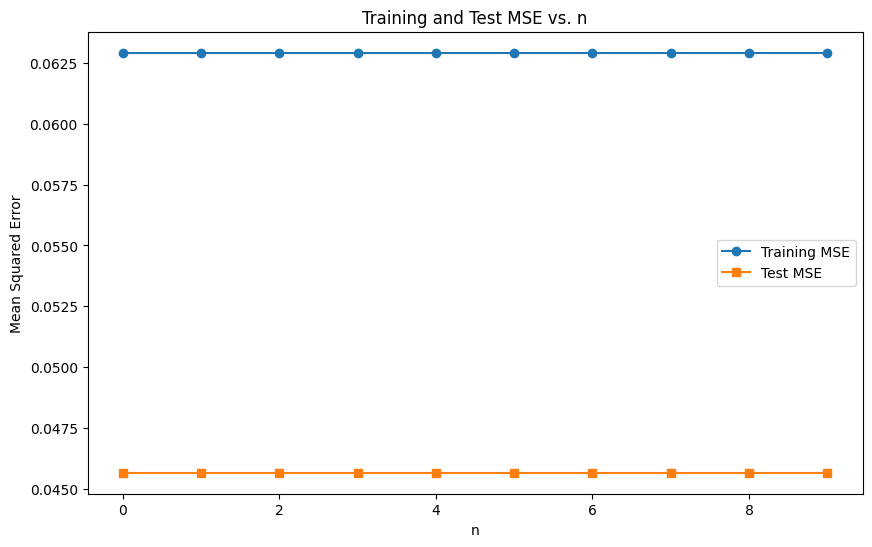

                       feature  importance
10                bandgap (eV)    0.323901
7          binding energy (eV)    0.241245
0                       atom_N    0.109109
1                        Radii    0.108369
6             badar charge (e)    0.059648
4                          i1     0.055868
2                    chemi_pot    0.033949
8        formation energy (eV)    0.027853
9             fermi level (eV)    0.020092
5   electron affinity (kJ/mol)    0.019967
3                        out_e    0.000000


In [5]:
n_range = np.arange(0, 10, 1)
train_mse_scores = []
test_mse_scores = []

for n in n_range:
    model = XGBRegressor(
        n_estimators=6,
        learning_rate=0.69,
        verbosity=1,
        random_state=RANDOM_STATE,
        reg_alpha=0,
        reg_lambda=5,
        max_depth=6,
        min_child_weight=0,
        gamma=0
    )
    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)

plt.figure(figsize=(10, 6))
plt.plot(n_range, train_mse_scores, marker='o', label='Training MSE')
plt.plot(n_range, test_mse_scores, marker='s', label='Test MSE')
plt.xlabel('n')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test MSE vs. n')
plt.legend()
plt.show()

importances = model.feature_importances_

feature_names = df.columns[:11]
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

print(feature_importances)

In [6]:
print(
    f"Metrics train:\n"
    f"\t MSR: {mean_squared_error(y_train, train_predictions):.4f} \n"
    f"\t MAR: {mean_absolute_error(y_train, train_predictions):.4f} \n"
    f"\t R2: {r2_score(y_train, train_predictions):.4f}"
)

print(
    f"Metrics test:\n"
    f"\t MSR: {mean_squared_error(y_test, test_predictions):.4f} \n"
    f"\t MAR: {mean_absolute_error(y_test, test_predictions):.4f} \n"
    f"\t R2: {r2_score(y_test, test_predictions):.4f}"
)

Metrics train:
	 MSR: 0.0629 
	 MAR: 0.1328 
	 R2: 0.9503
Metrics test:
	 MSR: 0.0457 
	 MAR: 0.1806 
	 R2: 0.9320


y_test:
0.2302822 -0.5561951 1.2165529 -0.67964
-1.5354418 1.6814899 -0.9536251 1.018577
0.1697882 -0.1203471 -0.9061961 1.067755
-0.0580658 0.4194929 -1.5998921 1.449465
-0.3465378 0.2165649 0.5956019 -0.254629
0.0340962 1.8146939 -1.0404931 -0.597297
-1.2555528 0.6796049 0.5968589 0.190089
test_predictions:
0.28321117 -0.9984759 1.4563681 -0.57966006
-1.852845 1.8316731 -0.6855085 1.343266
0.08078853 -0.20468253 -0.6440822 0.94867307
0.11488689 0.26103964 -1.2338647 1.5184511
-0.2669125 0.08905419 0.6413663 -0.24662726
-0.32617217 1.6326361 -0.86384505 -0.43121648
-1.1934637 0.5653948 0.2303132 0.34061334
y_train:
0.2616552 -1.1458221 1.6036669 -0.5085
0.1192952 1.6432389 -0.9382851 -0.613249
-0.1405148 -0.9938811 2.0543889 -0.708993
0.1658962 0.0909879 -0.6573451 0.611461
0.2691722 -1.1412971 1.5430709 -0.459946
-0.5412408 0.7063829 -0.0115871 0.057445
0.2146292 0.3062959 0.3741399 -0.684065
-3.2755308 -0.5979831 1.0861999 2.998314
-0.3106448 0.1226279 0.6537749 -0.254758
-2.4359258

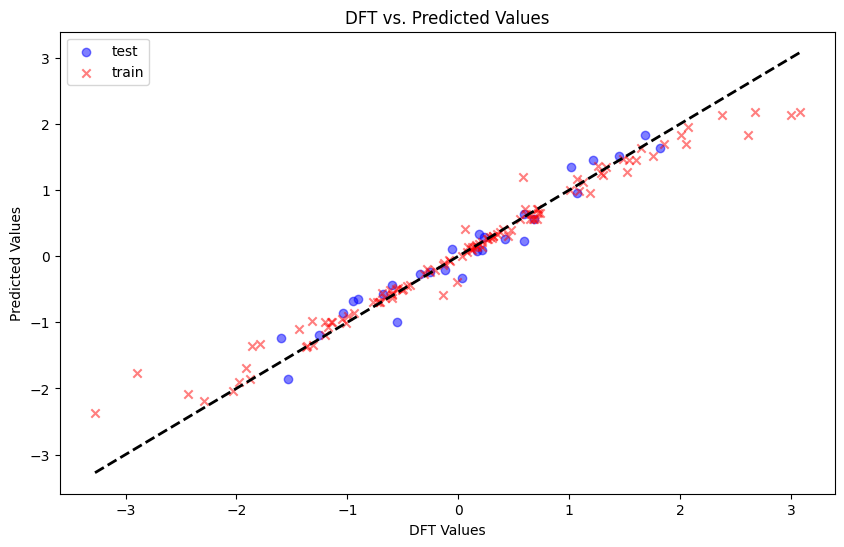

In [7]:
def print_no_brackets(array):
    for item in array:
        print(' '.join(map(str, item)))

print("y_test:")
print_no_brackets(y_test)

print("test_predictions:")
print_no_brackets(test_predictions)

print("y_train:")
print_no_brackets(y_train)

print("train_predictions:")
print_no_brackets(train_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5, color='blue', label='test', marker='o')
plt.scatter(y_train, train_predictions, alpha=0.5, color='red', label='train', marker='x')

plt.xlabel("DFT Values")
plt.ylabel("Predicted Values")
plt.title("DFT vs. Predicted Values")
plt.legend()

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import shap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap_data = {}

if isinstance(shap_values, list) and len(shap_values) == 4:
    for i in range(len(shap_values)):
        print(f"SHAP summary plot for target {i+1}")
        
       
        feature_names = [r'{}'.format(feature.replace('_', r'_\mathrm{')) + '}' if '_' in feature else feature for feature in df.columns[:11]]
else:
    print()

SHAP summary plot for target 1
SHAP summary plot for target 2
SHAP summary plot for target 3
SHAP summary plot for target 4


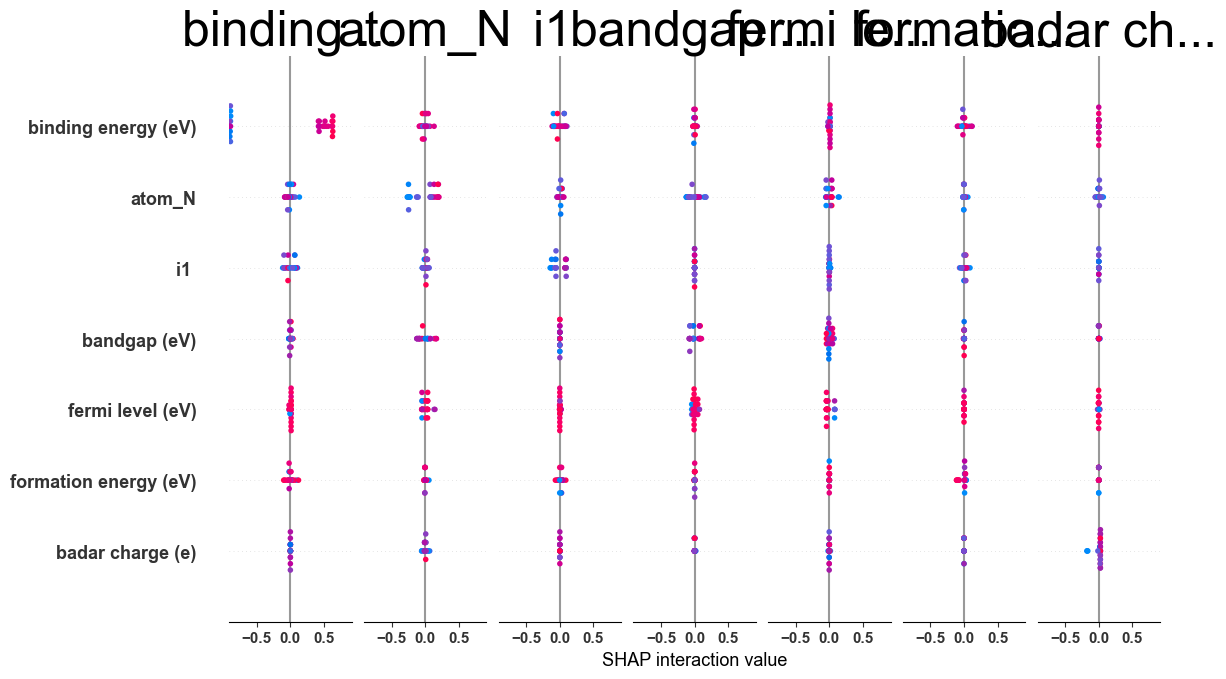

In [9]:
shap_interaction_values = explainer.shap_interaction_values(x_train)

shap.summary_plot(shap_interaction_values[0], x_train, feature_names=df.columns[:14])